# GRB image analysis (miniDC2)

updated on 2024-01-30 (commit 26cfdeacb25335bd511a91c4f8a29bdeb36408f2)

Using the GRB simulation data created for miniDC2, an example of the image analysis will be presented.

If you want to know about the other analysis, e.g., the spectral analysis, you can see the notebooks in docs/tutorials/spectral_fits.

**Note that it is not necessary to run the following cell when the headline is inside parentheses. These cells are prepared for readers to understand the code more clearly**

In [1]:
from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy import BinnedData, Band_Eflux
from cosipy.image_deconvolution import DataLoader, ImageDeconvolution, CoordsysConversionMatrix

from histpy import Histogram, HealpixAxis, Axis
from mhealpy import HealpixMap,HealpixBase

import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord, ICRS, Galactic, FK4, FK5
from astropy.time import Time
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from astromodels import Band
from threeML import Band, PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter

#Other standard libraries
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import healpy as hp
import os
import pprint

%matplotlib inline

Welcome to JupyROOT 6.24/06


18:26:12 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=104574;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=162846;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=92131;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=387679;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=263938;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=358655;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=428347;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=923620;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=446029;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=176680;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=780894;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=617851;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=166610;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=432103;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=683258;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=995765;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=668705;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=378616;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

18:26:12 INFO      Starting 3ML!                                                                     ]8;id=259287;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=98649;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=814211;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=973485;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=588349;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=182828;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=414890;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=873065;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=663678;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=444228;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

18:26:13 WARNING   PyGMO is not available                                                      ]8;id=289695;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=314749;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

18:26:13 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=723141;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=398241;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=689537;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=301480;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=902118;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=797243;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=446775;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=134701;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=251055;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=293236;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=616653;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=804009;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=262358;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=160543;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

# 0. Data reduction

Before running the cells, please download the files needed for this notebook. You can get them from wasabi. 

From wasabi
- cosi-pipeline-public/ComptonSphere/mini-DC2/FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip (please unzip it)
- cosi-pipeline-public/ComptonSphere/mini-DC2/bkg_binned_data_full.hdf5
- cosi-pipeline-public/ComptonSphere/mini-DC2/grb_binned_data.hdf5
- cosi-pipeline-public/ComptonSphere/mini-DC2/grb_bkg_binned_data.hdf5

From docs/tutorials/image_deconvolution/GRB
- 20280301_first_2hrs.ori
- grb_dataIO_config.yml
- imagedeconvolution_parfile_GRB_miniDC2.yml

You can download the data and detector response from wasabi. You can skip this cell if you already have downloaded the files

In [ ]:
file_list = ['FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip', 'bkg_binned_data_full.hdf5', 'grb_binned_data.hdf5', 'grb_bkg_binned_data.hdf5']

for each in file_list:
    os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key ComptonSphere/mini-DC2/%s --endpoint-url=https://s3.us-west-1.wasabisys.com %s" %(each,each))

In [ ]:
os.system("unzip FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip")

# 1. Read the response matrix

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [3]:
path_data = "path/to/data/"

In [4]:
response_path = path_data + "FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5"

response = FullDetectorResponse.open(response_path)

# 2. Read binned GRB files (source and background)

In [5]:
%%time

#  background over 2-hour observation
bkg_data = BinnedData(path_data + "grb_dataIO_config.yml")
bkg_data.load_binned_data_from_hdf5(path_data + 'bkg_binned_data_full.hdf5')

#  GRB + background around the event
grb_data = BinnedData(path_data + "grb_dataIO_config.yml")
grb_data.load_binned_data_from_hdf5(path_data + 'grb_bkg_binned_data.hdf5')

# only the GRB signal around the event (we don't use it in the analysis)
signal_data = BinnedData(path_data + "grb_dataIO_config.yml")
signal_data.load_binned_data_from_hdf5(path_data + 'grb_binned_data.hdf5')

CPU times: user 10.8 s, sys: 1.09 s, total: 11.9 s
Wall time: 12 s


## Check that the duration of bkg_data is 7200 sec = 2 hours

In [6]:
bkg_data.binned_data.axes['Time'].hi_lim - bkg_data.binned_data.axes['Time'].lo_lim

7200.0

## Check that the duration of grb_data is 2 sec

In [7]:
grb_data.binned_data.axes['Time'].hi_lim - grb_data.binned_data.axes['Time'].lo_lim

1.999995231628418

## Defne the scale factor for the background data

In [8]:
ratio_bkg_to_grbdata = (bkg_data.binned_data.axes['Time'].hi_lim - bkg_data.binned_data.axes['Time'].lo_lim) / (grb_data.binned_data.axes['Time'].hi_lim - grb_data.binned_data.axes['Time'].lo_lim)
ratio_bkg_to_grbdata

3600.0085830893113

## The start and stop times of the GRB binned data

In [9]:
grb_start_time = int(grb_data.binned_data.axes['Time'].lo_lim)
grb_stop_time = int(grb_data.binned_data.axes['Time'].hi_lim)

print("GRB start time:", grb_start_time)
print("GRB stop time:", grb_stop_time)

GRB start time: 1835481433
GRB stop time: 1835481435


## Modify the axis

<span style="color:red">Here the time axis in the data and background files are modified as a single time bin. This is because the current code requires the same time intervals in both files.</span>


<span style="color:red">The background files is renormalized because the background is 2-hour data while the source data is 2-s duration.</span>


<span style="color:red">Such a procedure might be confusing, but it will be improved in the future, for example, by introducing a user-friendly background generator.</span>

In [10]:
%%time

grb_data.binned_data = Histogram.concatenate(Axis([grb_start_time, grb_stop_time], label = 'Time'), [grb_data.binned_data.project('Em', 'Phi', 'PsiChi')])
bkg_data.binned_data = Histogram.concatenate(Axis([grb_start_time, grb_stop_time], label = 'Time'), [bkg_data.binned_data.project('Em', 'Phi', 'PsiChi')/ratio_bkg_to_grbdata])

CPU times: user 21.1 s, sys: 1.47 s, total: 22.6 s
Wall time: 22.8 s


### (View the events in Compton Data Space)

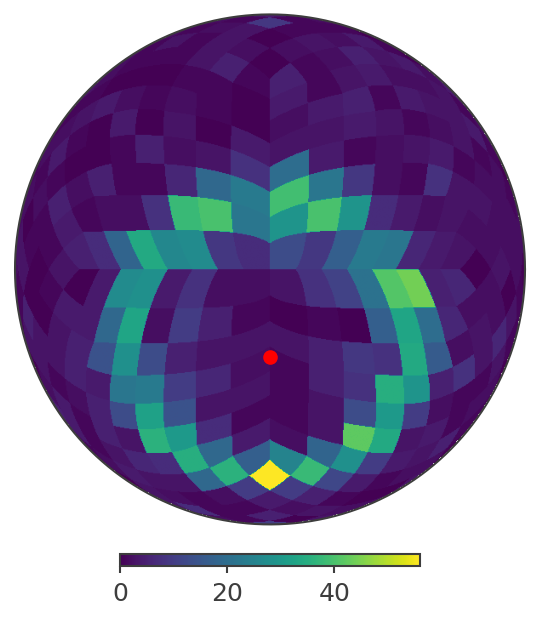

In [11]:
h = grb_data.binned_data.project('Em', 'Phi', 'PsiChi').slice[{'Em':2, 'Phi':3}].project('PsiChi')
m = HealpixMap(base = HealpixBase(npix = h.nbins), data = h.contents.todense())

_,ax = m.plot('orthview', ax_kw = {'rot':[0,90,0]})
#_,ax = m.plot('mollview')

ax.scatter(0, 70, transform=ax.get_transform('world'), color = 'red')

# 2. Calculate the coordinate conversion matrix

CoordsysConversionMatrix.spacecraft_time_binning_ccm can produce the ccm for the time binning.

Here we calculate the dwell time map on each sky pixel and each time bin, and then combine them as a coordinate conversion matrix (ccm).

The ccm $C^{lb, \nu\lambda}_{t}$ is a three-dimensional matrix with the axes of 'lb', 'Time' and 'NuLambda'.

$C^{lb, \nu\lambda}_{t}$ is the exposure time on the pixel $\nu\lambda$ on the detector coordinate for the model pixel $lb$ (in the galactic coordinate) during the time bin $t$.

By multiplying $C^{lb, \nu\lambda}_{t}$ with the model map, it can be converted into the detector coordinate for each time bin.

## Read the orientation file and extract the orientation information around the GRB event

In [12]:
ori = SpacecraftFile.parse_from_file(path_data + "20280301_first_2hrs.ori")

#Set the GRB duration
Timemin = Time(grb_start_time,format = 'unix')
Timemax = Time(grb_stop_time,format = 'unix')
grbori = ori.source_interval(Timemin, Timemax)

## Calculate the coordinate conversion matrix

In [13]:
%%time

time_intervals = grb_data.binned_data.axes['Time'].edges

coordsys_conv_matrix = CoordsysConversionMatrix.time_binning_ccm(response, 
                                                                 ori, 
                                                                 time_intervals, 
                                                                 nside_model = response.nside)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5.3 s, sys: 192 ms, total: 5.49 s
Wall time: 5.47 s


### (you can save/load the ccm as follows)

If you save the coordsys conversion matrix, you can load it and do not have to calculate it again, which may save your time.

In [14]:
coordsys_conv_matrix.write("coordsys_conv_matrix.hdf5", overwrite = True)

In [15]:
%%time

coordsys_conv_matrix = CoordsysConversionMatrix.open("coordsys_conv_matrix.hdf5")

CPU times: user 3.89 ms, sys: 1.75 ms, total: 5.63 ms
Wall time: 4.74 ms


### (calculate the dwell time map, not mandatory)

In [16]:
# Simulating a 2 second GRB at l = 51, b = -17 in Galacti coordinates.
coord = SkyCoord(l = 51*u.deg, b = -17*u.deg,
                 frame = 'galactic', attitude = Attitude.identity(frame = 'galactic')) 

In [17]:
# Initiate a SpacecraftPositionAttitude object with the coordinates of the source
#SCPosition = SpacecraftPositionAttitude.SourceSpacecraft("GRB", coord) 

# From the orientation, get the attitude and define the source movement in the spacecraft FOV
dts = grbori.get_time_delta()

src_movement = grbori.get_target_in_sc_frame("GRB", coord) 

Now converting to the Spacecraft frame...
Conversion completed!


In [18]:
dwell_time_map = grbori.get_dwell_map(response = response_path, dts = dts, src_path = src_movement)

Failed to transform from 'spacecraftframe' to 'icrs'. Rasterizing in 'spacecraftframe' frame. ERROR: Spacecraft coordinates need attitude to transform from ICRS


(<matplotlib.image.AxesImage at 0x2ca4a26e0>, <Mollview: >)

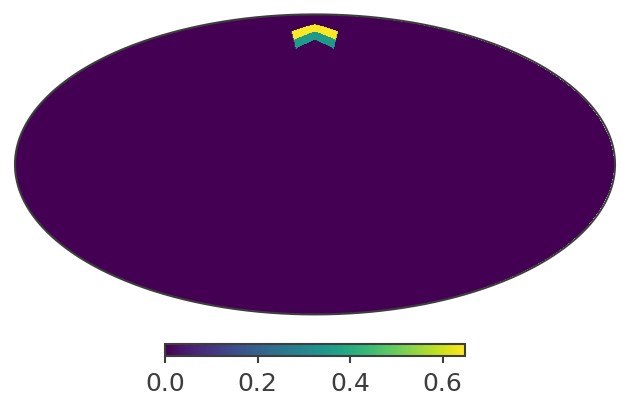

In [19]:
dwell_time_map.plot()

# 4. Imaging deconvolution

## Brief overview of the image deconvolution

Basically, we have to maximize the following likelihood function

$$
\log L = \sum_i X_i \log \epsilon_i - \sum_i \epsilon_i
$$

$X_i$: detected counts at $i$-th bin ( $i$ : index of the Compton Data Space)

$\epsilon_i = \sum_j R_{ij} \lambda_j + b_i$ : expected counts ( $j$ : index of the model space)

$\lambda_j$ : the model map (basically gamma-ray flux at $j$-th pixel)

$b_i$ : the background at $i$-th bin

$R_{ij}$ : the response matrix

Since we have to optimize the flux in each pixel, and the number of parameters is large, we adopt an iterative approach to find a solution of the above equation. The simplest one is the ML-EM (Maximum Likelihood Expectation Maximization) algorithm. It is also known as the Richardson-Lucy algorithm.

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \delta \lambda_{j}^{k}
$$
$$
\delta \lambda_{j}^{k} = \frac{\lambda_{j}^{k}}{\sum_{i} R_{ij}} \sum_{i} \left(\frac{ X_{i} }{\epsilon_{i}} - 1 \right) R_{ij} 
$$

We refer to $\delta \lambda_{j}^{k}$ as the delta map.

As for now, the two improved algorithms are implemented in COSIpy.

- Accelerated ML-EM algorithm (Knoedlseder+99)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \delta \lambda_{j}^{k}
$$
$$
\alpha^{k} < \mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k})
$$

Practically, in order not to accelerate the algorithm excessively, we set the maximum value of $\alpha$ ($\alpha_{\mathrm{max}}$). Then, $\alpha$ is calculated as:

$$
\alpha^{k} = \mathrm{min}(\mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k}), \alpha_{\mathrm{max}})
$$

- Noise damping using gaussian smoothing (Knoedlseder+05, Siegert+20)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \left[ w_j \delta \lambda_{j}^{k} \right]_{\mathrm{gauss}}
$$
$$
w_j = \left(\sum_{i} R_{ij}\right)^\beta
$$

$\left[ ... \right]_{\mathrm{gauss}}$ means that the differential image is smoothed by a gaussian filter.

## 4-1. Prepare DataLoader containing all neccesary datasets

In [20]:
dataloader = DataLoader.load(grb_data.binned_data, 
                             bkg_data.binned_data, 
                             response, 
                             coordsys_conv_matrix,
                             is_miniDC2_format = True)

DataLoader is a data container for the image deconvolution. It also calculates several auxiliary matrices for the analysis.

## 4-2. Load the response file

The response file will be loaded on the CPU memory. It requires a few GB. In the actual COSI satellite analysis, the response could be much larger, perhaps ~1TB wiht finer bin size. 

So loading it on the memory might be unrealistic in the future. The optimized (lazy) loading would be a next work.

In [21]:
%%time

dataloader.load_full_detector_response_on_memory()

  0%|          | 0/768 [00:00<?, ?it/s]

CPU times: user 17.1 s, sys: 15.4 s, total: 32.4 s
Wall time: 32.8 s


Here, we calculate an auxiliary matrix for the deconvolution. Basically, it is a response matrix projected into the model space ($\sum_{i} R_{ij}$). Currently, it is mandatory to run this command for the image deconvolution.

In [22]:
dataloader.calc_image_response_projected()

... (DataLoader) calculating a projected image response ...


In [23]:
dataloader._modify_axes()

... checking the axis Time of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.



WARNING FutureWarning: Note that _modify_axes() in DataLoader was implemented for a temporary use. It will be removed in the future.


WARNING UserWarning: Make sure to perform _modify_axes() only once after the data are loaded.



## 4-4. Initialize the instance of the image deconvolution class

First, we prepare an instance of the ImageDeconvolution class and then register the dataset and parameters for the deconvolution. After that, you can start the calculation.

<span style="color:red"> please modify this parameter_filepath corresponding to your environment.</span>

In [24]:
parameter_filepath = path_data + "imagedeconvolution_parfile_GRB_miniDC2.yml"

In [25]:
image_deconvolution = ImageDeconvolution()

# set dataloader to image_deconvolution
image_deconvolution.set_data(dataloader)

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

data for image deconvolution was set ->  <cosipy.image_deconvolution.data_loader.DataLoader object at 0x2ca361990>
parameter file for image deconvolution was set ->  /Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/miniDC2/example_notebook//imagedeconvolution_parfile_GRB_miniDC2.yml


### Initialize image_deconvolution

In this process, a model map is defined following the input parameters, and it is initialized. Also, it prepares ancillary data for the image deconvolution, e.g., the expected counts with the initial model map, gaussian smoothing filter etc.

I describe parameters in the parameter file.

#### model_property

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| coordinate | str | the coordinate system of the model map | As for now, it must be 'galactic' |
| nside | int | NSIDE of the model map | it must be the same as NSIDE of 'lb' axis of the coordinate conversion matrix|
| scheme | str | SCHEME of the model map | As for now, it must be 'ring' |
| energy_edges | list of float [keV] | The definition of the energy bins of the model map | As for now, it must be the same as that of the response matrix |

#### model_initialization

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| algorithm | str | the method name to initialize the model map | As for now, only 'flat' can be used |
| parameter_flat:values | list of float [cm-2 s-1 sr-1] | the list of photon fluxes for each energy band | the length of the list should be the same as the length of "energy_edges" - 1 |

#### deconvolution

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
|algorithm | str | the name of the image deconvolution algorithm| As for now, only 'RL' is supported |
|||||
|parameter_RL:iteration | int | The maximum number of the iteration | |
|parameter_RL:acceleration | bool | whether the accelerated ML-EM algorithm (Knoedlseder+99) is used | |
|parameter_RL:alpha_max | float | the maximum value for the acceleration parameter | |
|parameter_RL:save_results_each_iteration | bool | whether an updated model map, detal map, likelihood etc. are saved at the end of each iteration | |
|parameter_RL:response_weighting | bool | whether a delta map is renormalized based on the exposure time on each pixel, namely $w_j = (\sum_{i} R_{ij})^{\beta}$ (see Knoedlseder+05, Siegert+20) | |
|parameter_RL:response_weighting_index | float | $\beta$ in the above equation | |
|parameter_RL:smoothing | bool | whether a Gaussian filter is used (see Knoedlseder+05, Siegert+20)  | |
|parameter_RL:smoothing_FWHM | float, degree | the FWHM of the Gaussian in the filter | |
|parameter_RL:background_normalization_fitting | bool | whether the background normalization factor is optimized at each iteration | As for now, the single background normalization factor is used in all of the bins |
|parameter_RL:background_normalization_range | list of float | the range of the normalization factor | should be positive |

In [26]:
image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 100.0
- 200.0
- 500.0
- 1000.0
- 2000.0
- 5000.0
nside: 8
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 0.01
  - 0.01
  - 0.01
  - 0.01
  - 0.01

3. registering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/768 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 10.0
  background_normalization_fitting: false
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 100
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 2.0
  smoothing_max_sigma: 10.0

#### Done ####



### (You can change the parameters as follows)

Note that when you modify the parameters, do not forget to run "initialize" again!

In [27]:
image_deconvolution.override_parameter("deconvolution:parameter_RL:iteration = 30")
image_deconvolution.override_parameter("deconvolution:parameter_RL:background_normalization_fitting = True")
image_deconvolution.override_parameter("deconvolution:parameter_RL:alpha_max = 5")
image_deconvolution.override_parameter("deconvolution:parameter_RL:smoothing_FWHM = 4.0")

image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 100.0
- 200.0
- 500.0
- 1000.0
- 2000.0
- 5000.0
nside: 8
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 0.01
  - 0.01
  - 0.01
  - 0.01
  - 0.01

3. registering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/768 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 5
  background_normalization_fitting: true
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 30
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 4.0
  smoothing_max_sigma: 10.0

#### Done ####



## 4-5. Start the image deconvolution

**With MacBook Pro with M1 Max and 64 GB memory, it takes about 40 seconds for 30 iterations.**

In [28]:
%%time

all_results = image_deconvolution.run_deconvolution()

#### Deconvolution Starts ####


  0%|          | 0/30 [00:00<?, ?it/s]

  Iteration 1/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step



WARNING RuntimeWarning: invalid value encountered in divide



--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 4.5256721171422285
    loglikelihood: 6995.070394357579
    background_normalization: 1.9156089682929596
  Iteration 2/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.5763136603313757
    loglikelihood: 24101.13650415292
    background_normalization: 1.3793746628449184
  Iteration 3/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 4.754476734122631
    loglikelihood: 25829.656262774864
    ba

In [29]:
pprint.pprint(all_results)

[{'alpha': <Quantity 4.52567212>,
  'background_normalization': 1.9156089682929596,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2ca56d4e0>,
  'iteration': 1,
  'loglikelihood': 6995.070394357579,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2ca56cac0>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2ca56ed40>},
 {'alpha': <Quantity 1.57631366>,
  'background_normalization': 1.3793746628449184,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2ca56d0c0>,
  'iteration': 2,
  'loglikelihood': 24101.13650415292,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2ca56c9a0>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2ca56fa60>},
 {'alpha': <Quantity 4.75447673>,
  'background_normalization': 1.479120638470411,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2ca56e650>,
  'iteration': 3,
  

# 5. Analyze the results

Examples to see/analyze the results are shown below.

## Log-likelihood

Plotting the log-likelihood vs the number of iterations

Text(0, 0.5, 'loglikelihood')

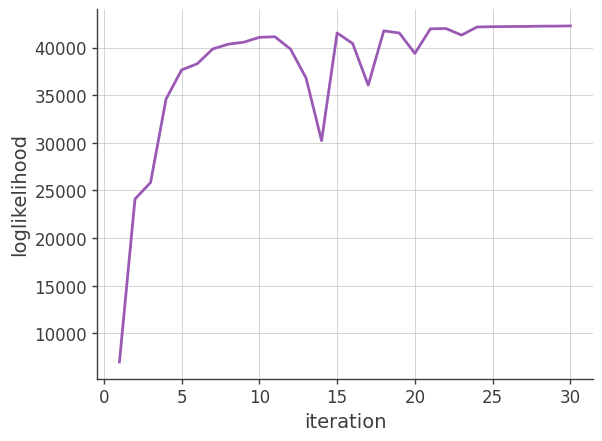

In [30]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")

## Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

Text(0, 0.5, 'alpha')

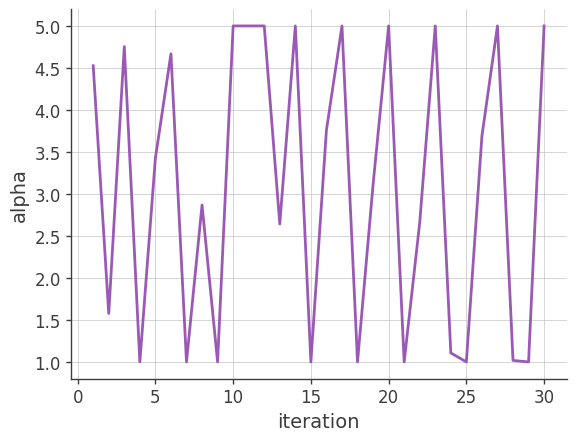

In [31]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")

## Background normalization

Plotting the background nomalization factor vs the number of iterations. If the backgroud model is accurate and the image is reconstructed perfectly, this factor should be close to 1. In this case, the background is slightly off from one, which may be because the background events are extracted from different time intervals of the GRB events.

Text(0, 0.5, 'background_normalization')

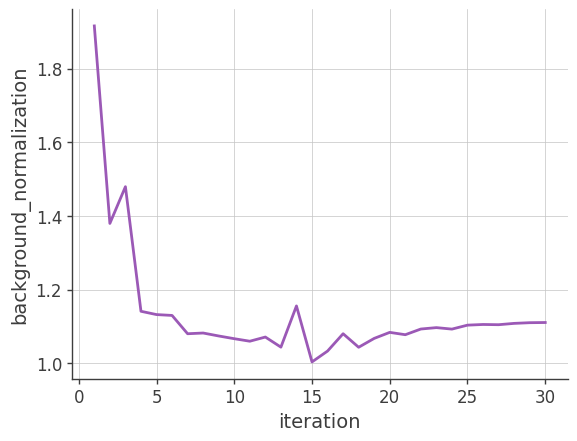

In [32]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['background_normalization'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")

## The reconstructed images

In [33]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

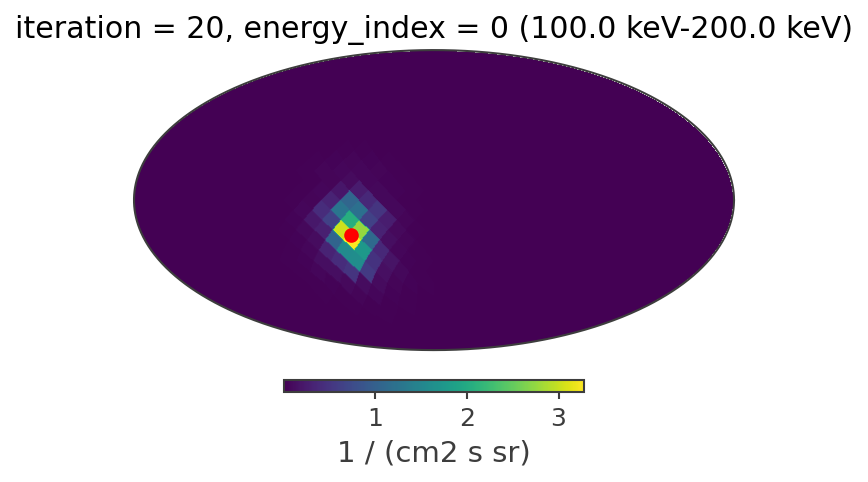

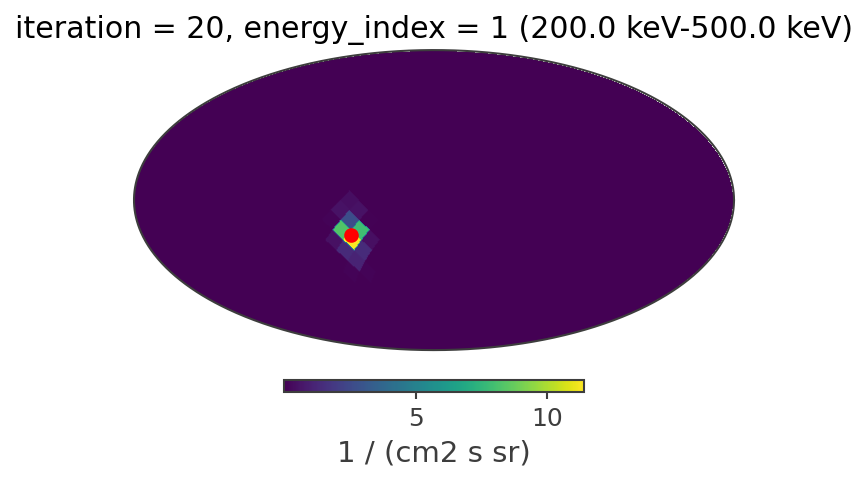

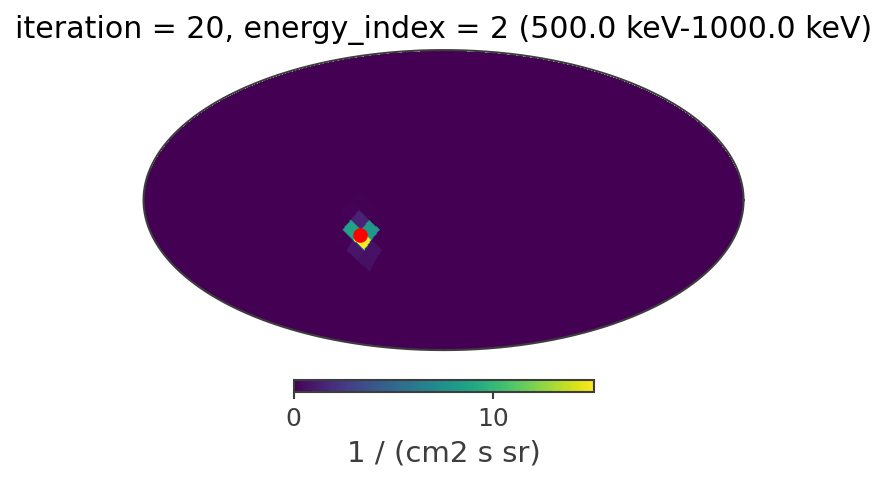

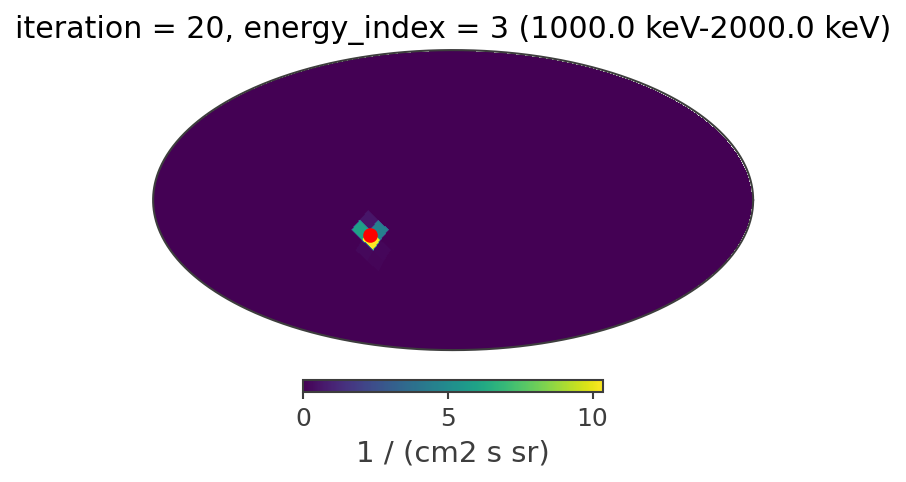

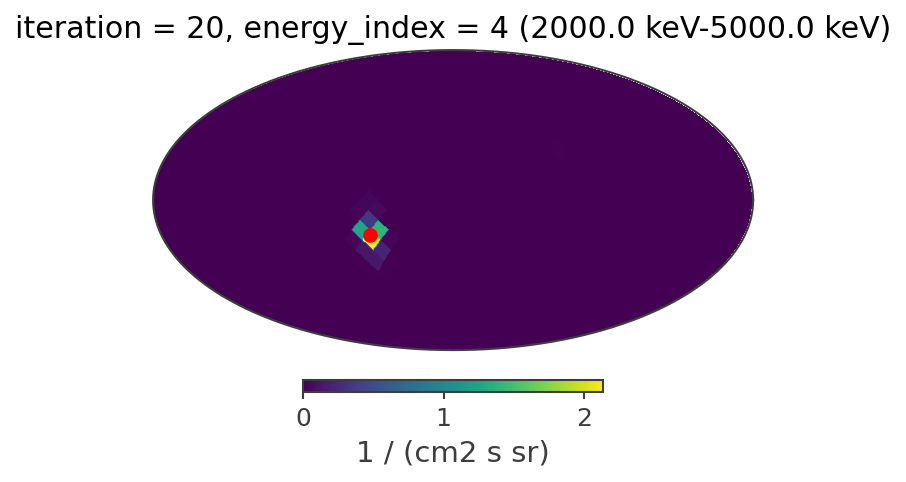

In [34]:
iteration = 19

plot_reconstructed_image(all_results[iteration], source_position = (51 * u.deg, -17 * u.deg))

You can plot the reconstructed images from all of the iterations. Note that the following cell produces lots of figures.

In [ ]:
for result in all_results:
    plot_reconstructed_image(result, source_position = (51 * u.deg, -17 * u.deg))

## Delta image
checking the difference between images before/after each iteration

In [36]:
def plot_delta_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['delta_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the difference between 19th and 20th reconstructed images.

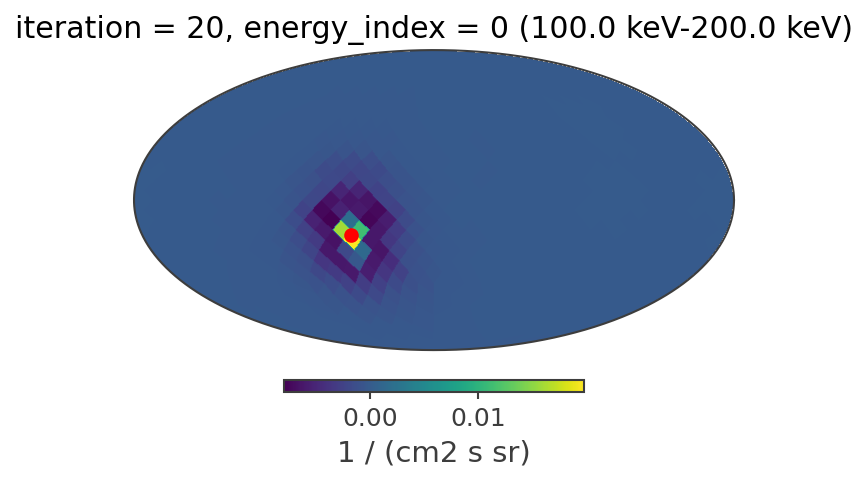

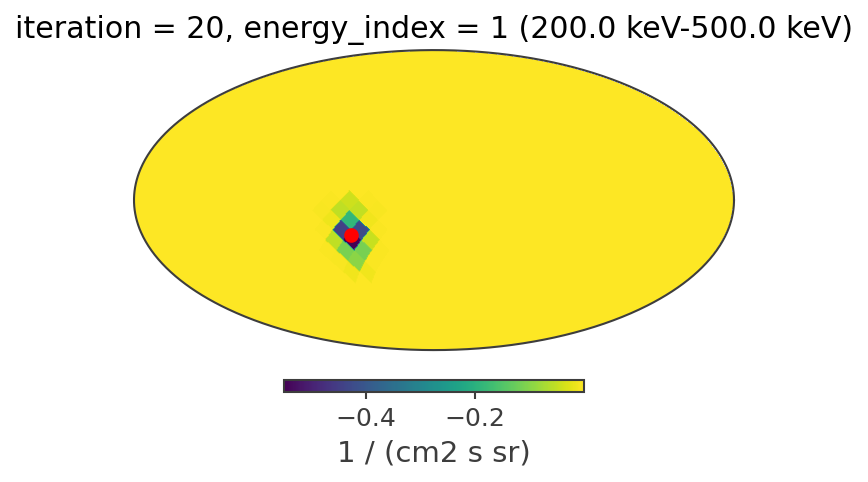

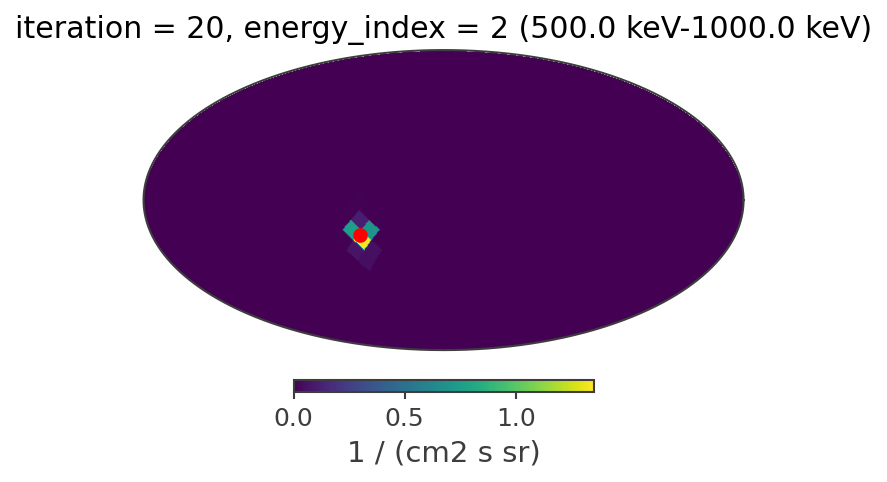

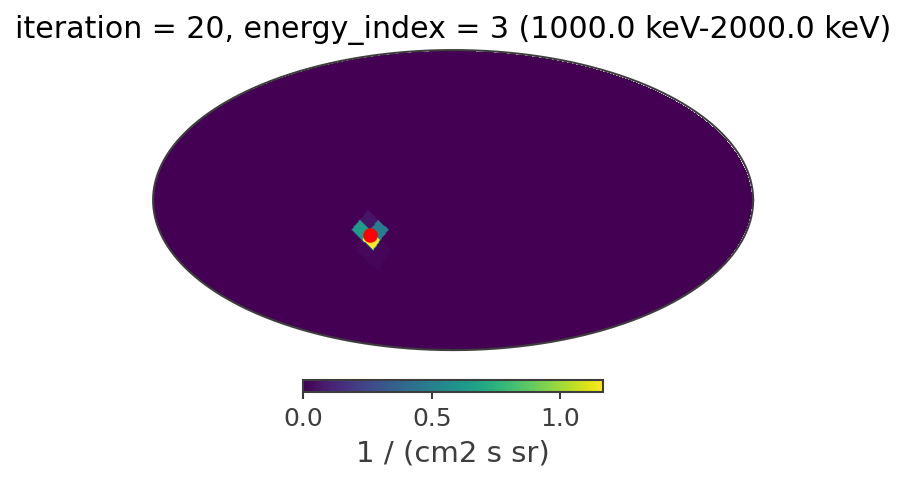

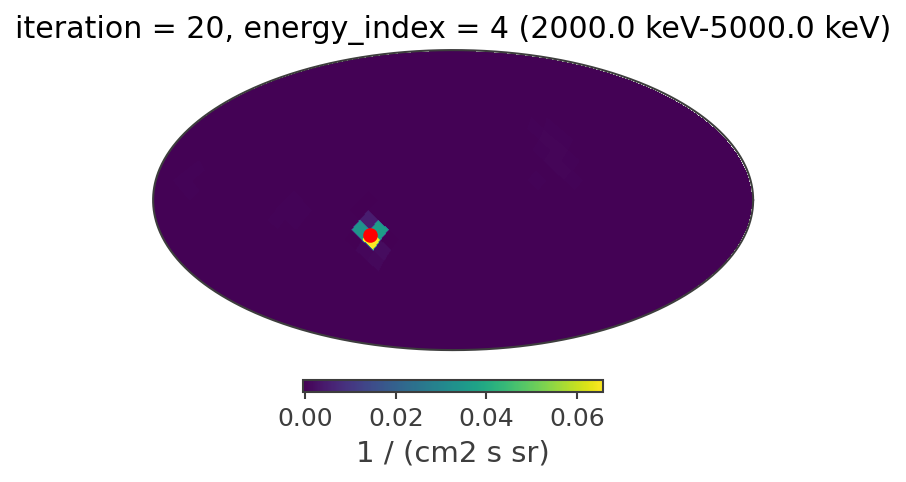

In [37]:
iteration = 19

plot_delta_image(all_results[iteration], source_position = (51 * u.deg, -17 * u.deg))

You can plot the reconstructed images from all of the iterations. Note that the following cell produces lots of figures.

In [ ]:
for result in all_results:
    plot_delta_image(result, source_position = (51 * u.deg, -17 * u.deg))

## Integrated flux over the sky

Define the actual GRB spectral model

In [38]:
alpha_inj = -1.
beta_inj = -3.
E0_inj = 1000. * u.keV 
K_inj = 5. / u.cm / u.cm / u.s / u.keV             
Emin_inj = 10. * u.keV
Emax_inj = 5000. * u.keV

spectrum_inj = Band_Eflux(alpha=alpha_inj,
                          beta=beta_inj,
                          E0=E0_inj.value,
                          K=K_inj.value,
                          a=Emin_inj.value,
                          b=Emax_inj.value)

spectrum_inj.E0.unit = E0_inj.unit
spectrum_inj.K.unit = K_inj.unit
spectrum_inj.a.unit = Emin_inj.unit
spectrum_inj.b.unit = Emax_inj.unit

Calculate the integrated photon flux in each energy band

In [39]:
integrated_flux_each_band_truth = []
integrated_flux_truth = 0.0 / u.cm**2 / u.s

for energy_index in range(all_results[0]['model_map'].axes["Ei"].nbins):
    emin, emax = all_results[0]['model_map'].axes["Ei"].bounds[energy_index]

    integrated_flux_each_band_truth.append(integrate.quad(spectrum_inj, emin.value, emax.value)[0] / u.cm**2 / u.s)
    
    print(emin, emax)
    print("    truth:", integrated_flux_each_band_truth[energy_index])
    
    integrated_flux_truth += integrated_flux_each_band_truth[-1]

100.0 keV 200.0 keV
    truth: 0.7418347986463156 1 / (cm2 s)
200.0 keV 500.0 keV
    truth: 0.8192020113325374 1 / (cm2 s)
500.0 keV 1000.0 keV
    truth: 0.420663133134687 1 / (cm2 s)
1000.0 keV 2000.0 keV
    truth: 0.21068821854253272 1 / (cm2 s)
2000.0 keV 5000.0 keV
    truth: 0.07024548561978913 1 / (cm2 s)


Plotting the integratd flux in each energy band vs the number of interations

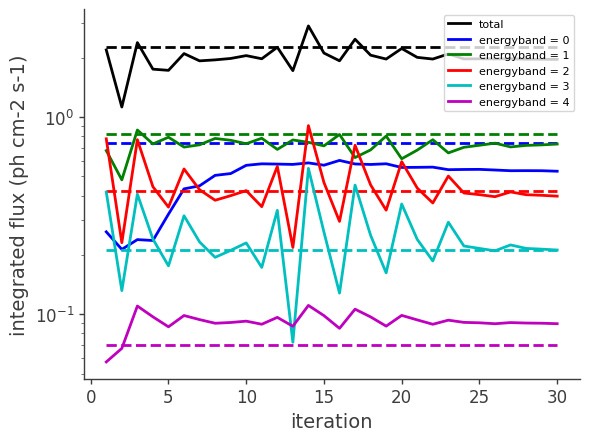

In [40]:
iteration = []
integrated_flux = []
integrated_flux_each_band = [[],[],[],[],[]]

for result in all_results:
    iteration.append(result['iteration'])
    image = result['model_map']
    pixelarea = 4 * np.pi / image.axes['lb'].npix * u.sr

    integrated_flux.append(np.sum(image) * pixelarea)

    for energy_band in range(image.axes['Ei'].nbins):
        integrated_flux_each_band[energy_band].append(np.sum(image[:,energy_band]) * pixelarea)
                
plt.plot(iteration, [_.value for _ in integrated_flux], label = 'total', color = 'black')
plt.plot(iteration, np.full(len(iteration), integrated_flux_truth), color = 'black', linestyle = "--")
plt.xlabel("iteration")
plt.ylabel("integrated flux (ph cm-2 s-1)")
plt.yscale("log")

colors = ['b', 'g', 'r', 'c', 'm']
for energy_band in range(5):
    plt.plot(iteration, [_.value for _ in integrated_flux_each_band[energy_band]], color = colors[energy_band], label = "energyband = {}".format(energy_band))
    plt.plot(iteration, np.full(len(iteration), integrated_flux_each_band_truth[energy_band]), color = colors[energy_band], linestyle = "--")

plt.legend()

## Spectrum

Plotting the gamma-ray spectrum at 20th interation. The photon flux at each energy band shown here is calculated as the accumulation of the flux values in all pixel at each energy band.

In [41]:
def get_differential_flux(model_map):
    pixelarea = 4 * np.pi / model_map.axes['lb'].npix * u.sr
        
    differential_flux = np.sum(model_map, axis = 0) * pixelarea / model_map.axes['Ei'].widths
    
    return differential_flux

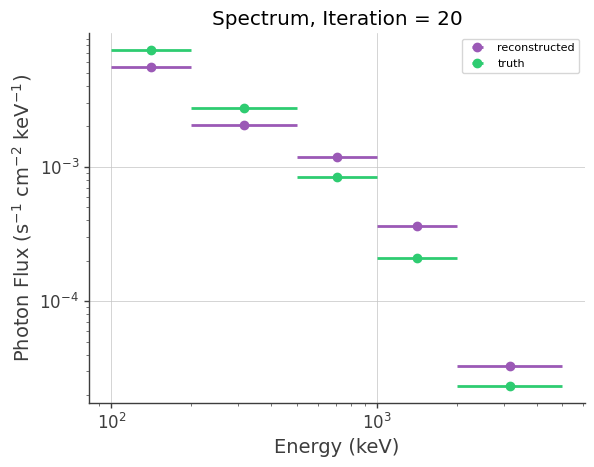

In [42]:
iteration = 19

result = all_results[iteration]

model_map = result['model_map']

differential_flux = get_differential_flux(model_map)

energy_band = model_map.axes['Ei'].centers

err_energy = model_map.axes['Ei'].bounds.T - model_map.axes['Ei'].centers
err_energy[0,:] *= -1

differential_flux_truth = [ integrated_flux / width for integrated_flux, width in zip(integrated_flux_each_band_truth, model_map.axes['Ei'].widths)]
        
plt.errorbar(energy_band, differential_flux, xerr=err_energy, fmt='o', label = 'reconstructed')
plt.errorbar(energy_band, [_.value for _ in differential_flux_truth], xerr=err_energy, fmt='o', label = 'truth')
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy (keV)")
plt.ylabel(r"Photon Flux (s$^{-1}$ cm$^{-2}$ keV$^{-1}$)")
plt.title(f"Spectrum, Iteration = {result['iteration']}")
plt.grid()
plt.legend()

## Find the location with the maximum flux
As an example, here it calculate the location of the maximum flux at the 20th iteration's map at the highest energy bin 

In [43]:
idx_iteration = 19
idx_energy = 4

argmax = np.argmax(all_results[idx_iteration]["model_map"].contents[:,idx_energy:idx_energy+1])
nside = all_results[idx_iteration]["model_map"].axes["lb"].nside
coordsys = all_results[idx_iteration]["model_map"].axes["lb"].coordsys

theta, phi = hp.pix2ang(nside, argmax)

l, b = phi * 180 / np.pi, 90 - theta * 180 / np.pi

c = SkyCoord(l, b, unit="deg", frame = coordsys)

print(f"The source position is around (l ,b) = ({c.galactic.l.deg} deg., {c.galactic.b.deg} deg.) in galactic")
print(f"The source position is around (ra, dec) = ({c.icrs.ra.deg} deg., {c.icrs.dec.deg} deg.) in icrs")

The source position is around (l ,b) = (50.62499999999999 deg., -19.47122063449069 deg.) in galactic
The source position is around (ra, dec) = (308.30194136772735 deg., 5.913074059175163 deg.) in icrs
